# Predict Future Sales

## How to

You don't have to do anything special, pretrained models are provided. Simply clone repo, run this notebook and enjoy. 

Can send result_lgb+lr.csv file for evaluation

## Requirements

Notebook was created in typical anaconda environment

Uncomment and run cell below. to install lightgbm (if needed)

In [1]:
#!pip install lightgbm

In [2]:
import pathlib
import json
import pandas as pd
import numpy as np
import random
from itertools import product
import gc
import tqdm.notebook as tqdm
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, PredefinedSplit
import lightgbm as lgb
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import csr_matrix
from scipy.sparse import hstack, vstack
import pickle
from sklearn.model_selection import StratifiedKFold
import time
start = time.time()


## Utility methods

In [3]:
random.seed(0)
def downcast_dtypes(df):    
    # Select columns to downcast
    float_cols = [c for c in df if df[c].dtype == "float64"]
    int_cols =   [c for c in df if df[c].dtype == "int64"]
    
    # Downcast
    df[float_cols] = df[float_cols].astype(np.float32)
    df[int_cols]   = df[int_cols].astype(np.int32)
    
    return df

def concat_df(train_data, test_data):
    return pd.concat([train_data, test_data], sort=True).reset_index(drop=True), train_data.shape[0]

def divide_df(all_data, train_size):
    if 'target' in all_data:
        return all_data.loc[:train_size-1], all_data.loc[train_size:].drop(['target'], axis=1)
    return all_data.loc[:train_size-1], all_data.loc[train_size:]

def get_result_df(predict):
    result = pd.DataFrame(data={'ID': range(0, 214200), 'item_cnt_month': predict})
    result['item_cnt_month'] = result['item_cnt_month'].clip(0, 20)
    return result

def get_mix(alpha, X):
    return (alpha * X[:,0]) + ((1-alpha) * X[:,1])

def get_best_alpha(X_train_level2, target):
    alphas_to_try = np.linspace(0, 1, 1001)
    min_mse = 100
    best_alpha = 1
    
    for alpha in alphas_to_try:
        mix = get_mix(alpha, X_train_level2)
        mse = mean_squared_error(target, mix)
        if min_mse > mse:
            min_mse = mse
            best_alpha = alpha
    return best_alpha

# this factor is needed for pipeline testing, make < 1 to reduce amount of data in work
cv_fraction = 0.1
def get_items_subset(X_train): 
    item_set = X_train['item_id'].unique()
    #random.shuffle(item_set)
    l = int(len(item_set) * cv_fraction)
    cv_item_set = item_set[:l]
    return X_train['item_id'].isin(cv_item_set)

## Data read

In [4]:
df_train = pd.read_csv('sales_train.csv')
df_test = pd.read_csv('test.csv')
df_shops = pd.read_csv('shops.csv')
df_items = pd.read_csv('items.csv')
df_item_cats = pd.read_csv('item_categories.csv')

In [5]:
ENABLE_PRICE_STATS = False
enable_subtype_code_mean = False

## Feature engineering

In [6]:
# removing item_cnt_day outliers
def remove_outlier(df_train, col):
    Q1 = df_train[col].quantile(0.25)
    Q3 = df_train[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = (df_train[col] > Q3+1.5*IQR)
    df_train[outliers].shape
    df_train.drop(df_train[outliers].index, inplace=True)
#remove_outlier(df_train, 'item_cnt_day')
#remove_outlier(df_train, 'item_price')

In [7]:
# ADD MONTH why not added??? -bad result (not one hot encoded) least for trees

# can be good of LR
#df_train['month'] = pd.to_datetime(df_train['date'], format='%d.%m.%Y').dt.month
# TODO add week, then add mean by week?

# FIX SHOPS

# Якутск Орджоникидзе, 56
df_train.loc[df_train.shop_id == 0, 'shop_id'] = 57
df_test.loc[df_test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
df_train.loc[df_train.shop_id == 1, 'shop_id'] = 58
df_test.loc[df_test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
df_train.loc[df_train.shop_id == 10, 'shop_id'] = 11
df_test.loc[df_test.shop_id == 10, 'shop_id'] = 11

In [8]:
# Create igem categories and cities from shops

# Extract type and sub type code
df_item_cats['split'] = df_item_cats['item_category_name'].str.split('-')
df_item_cats['type'] = df_item_cats['split'].map(lambda x: x[0].strip())
df_item_cats['type_code'] = LabelEncoder().fit_transform(df_item_cats['type'])
# if subtype is nan then type
df_item_cats['subtype'] = df_item_cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
df_item_cats['subtype_code'] = LabelEncoder().fit_transform(df_item_cats['subtype'])

# features = 10
# tfidf = TfidfVectorizer(max_features=features)
# df_item_cats['item_category_name'] = df_item_cats['item_category_name'].replace('[0-9!"\?\.)(,\+\*\[\]/:\-\'&]', ' ', regex=True)
# txtFeatures = pd.DataFrame(tfidf.fit_transform(df_item_cats['item_category_name']).toarray())
# cols = txtFeatures.columns

df_item_cats = df_item_cats[['item_category_id','type_code', 'subtype_code']]
# for i in range(features):
#     df_item_cats['item_category_tfidf_' + str(i)] = txtFeatures[cols[i]]

# Extract city
df_shops.loc[df_shops['shop_name'] == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
df_shops['city'] = df_shops['shop_name'].str.split(' ').map(lambda x: x[0])
df_shops.loc[df_shops.city == '!Якутск', 'city'] = 'Якутск'

# add distance to Moscow?

df_shops['city_code'] = LabelEncoder().fit_transform(df_shops['city'])
df_shops = df_shops[['shop_id','city_code']]

In [9]:
# Processing text features

df_items_txt = df_items[['item_id', 'item_name']]
df_items_txt['item_name'] = df_items_txt['item_name'].replace('[0-9!"\?\.)(,\+\*\[\]/:\-\'&]', ' ', regex=True)

features = 10
tfidf = TfidfVectorizer(max_features=features)
df_items_txt['item_name_len'] = df_items_txt['item_name'].map(len)  
df_items_txt['item_name_wc'] = df_items_txt['item_name'].map(lambda x: len(str(x).split(' '))) 
txtFeatures = pd.DataFrame(tfidf.fit_transform(df_items_txt['item_name']).toarray())
cols = txtFeatures.columns

for i in range(features):
    df_items_txt['item_name_tfidf_' + str(i)] = txtFeatures[cols[i]]

df_items_txt.drop(columns=['item_name'], inplace=True)


C:\Users\aimar\anaconda3\envs\kaggle\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


#### Prepare mean encodings

In [10]:
index_cols = ['shop_id', 'item_id', 'date_block_num']

def get_all_data(df):    
    
    sales = df.copy()
    sales = pd.merge(sales, df_items[['item_id','item_category_id']], how='left', on='item_id')
    sales = pd.merge(sales, df_item_cats, how='left', on='item_category_id')
    # Create "grid" with columns
    
    # For every month we create a grid from all shops/items combinations from that month
    grid = [] 
    for block_num in sales['date_block_num'].unique():
        cur_shops = sales.loc[sales['date_block_num'] == block_num, 'shop_id'].unique()
        cur_items = sales.loc[sales['date_block_num'] == block_num, 'item_id'].unique()
        grid.append(np.array(list(product(*[cur_shops, cur_items, [block_num]])), dtype='int32'))
    
    # Turn the grid into a dataframe
    grid = pd.DataFrame(np.vstack(grid), columns = index_cols,dtype=np.int32)
    
    # Groupby data to get shop-item-month aggregates
    gb = sales.groupby(index_cols, as_index=False).agg({'item_cnt_day':'sum'})
    gb['item_cnt_day'] = gb['item_cnt_day'].clip(0, 20)
    gb.rename(columns={'item_cnt_day': 'target'}, inplace=True)
    
    # Fix column names
    # Join it to the grid
    all_data = pd.merge(grid, gb, how='left', on=index_cols).fillna(0)#0.334?
    
    # Same as above but with shop-month aggregates
    gb = sales.groupby(['shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':'sum'})
    gb['item_cnt_day'] = gb['item_cnt_day'].clip(0, 20)
    gb.rename(columns={'item_cnt_day': 'target_shop'}, inplace=True)
    all_data = pd.merge(all_data, gb, how='left', on=['shop_id', 'date_block_num']).fillna(0)
    
    # Same as above but with item-month aggregates
    gb = sales.groupby(['item_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':'sum'})
    gb['item_cnt_day'] = gb['item_cnt_day'].clip(0, 20)
    gb.rename(columns={'item_cnt_day': 'target_item'}, inplace=True)
    all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'date_block_num']).fillna(0)    
    
    ### Advanced features statistics for price
    # mean price
    if ENABLE_PRICE_STATS:
        gb = sales.groupby(['item_id', 'shop_id', 'date_block_num'],as_index=False).agg({'item_price':'mean'})
        gb.columns = ['item_id', 'shop_id', 'date_block_num', 'item_price_mean']
        all_data = pd.merge(all_data, gb, how='left', on=['item_id', 'shop_id', 'date_block_num']).fillna(0)
        
        all_data['sale_total'] = all_data['target'] * all_data['item_price_mean']
        
    if enable_subtype_code_mean:
        # min/max price by 'subtype_code'
        all_data = pd.merge(all_data, sales[['item_id','item_category_id']].drop_duplicates(), how='left', on='item_id')
        all_data = pd.merge(all_data,  df_item_cats[['item_category_id', 'subtype_code']], how='left', on='item_category_id')
        gb = sales.groupby(['subtype_code', 'shop_id', 'date_block_num'],as_index=False).agg({'item_cnt_day':'sum'})
        gb['item_cnt_day'] = gb['item_cnt_day'].clip(0, 20)
        gb.columns = ['subtype_code', 'shop_id', 'date_block_num', 'target_subtype_code']
        all_data = pd.merge(all_data, gb, how='left', on=['subtype_code', 'shop_id', 'date_block_num']).fillna(0)
        
        all_data.drop(columns=['item_category_id', 'subtype_code'], inplace=True)
    
    df_test_concat = df_test.drop(columns=['ID'])
    df_test_concat['date_block_num'] = 34
    all_data, TRAIN_SIZE = concat_df(all_data, df_test_concat)
    
    all_data = downcast_dtypes(all_data)
#     del grid, gb, df_test_concat, sales, df_test
#     gc.collect();
    return all_data, TRAIN_SIZE


#### Prepare historical lags item

In [11]:
shift_range = [1, 2, 3, 4, 5, 12]

def get_lags(df):
    
    # List of columns that we will use to create lags
    cols_to_rename = list(df.columns.difference(index_cols)) 
    
    df = df.copy()
    for month_shift in tqdm.tqdm(shift_range):
        train_shift = df[index_cols + cols_to_rename].copy()
        
        train_shift['date_block_num'] = train_shift['date_block_num'] + month_shift
        
        foo = lambda x: '{}_lag_{}'.format(x, month_shift) if x in cols_to_rename else x
        train_shift = train_shift.rename(columns=foo)
    
        df = pd.merge(df, train_shift, on=index_cols, how='left').fillna(0)
    
    del train_shift
    
    # try to delete medians
    df.drop(columns=['target_shop', 'target_item'], inplace=True)
    if ENABLE_PRICE_STATS:
        df.drop(columns=['item_price_mean', 'sale_total'], inplace=True)
        
    if enable_subtype_code_mean:    
        df.drop(columns=['target_subtype_code'], inplace=True)
    
    # List of all lagged features
    fit_cols = [col for col in df.columns if col[-1] in [str(item) for item in shift_range]] 
    # We will drop these at fitting stage
    to_drop_cols = list(set(list(df.columns)) - (set(fit_cols)|set(index_cols))) + ['date_block_num'] 
    
    # Category for each item
    item_category_mapping = df_items[['item_id','item_category_id']].drop_duplicates()
    
    df = pd.merge(df, item_category_mapping, how='left', on='item_id')
    df = pd.merge(df, df_item_cats, how='left', on='item_category_id')
    df = pd.merge(df, df_shops, how='left', on='shop_id')
    df = pd.merge(df, df_items_txt, how='left', on='item_id')
    
#     months = df_train.groupby(['date_block_num'], as_index=False)['month'].mean()
    
#     df = pd.merge(df, months, how='left', on='date_block_num')
    
#     df['month'] = ((df['date_block_num'] % 12)+1)
    
    
    
    # generating categorical interaction feature for experiment/education
    # all_data['item_category_id_city_code'] = all_data['item_category_id'].astype(str) + '_' + all_data['city_code'].astype(str)
    # all_data['item_category_id_city_code'] = LabelEncoder().fit_transform(all_data['item_category_id_city_code'])
    return downcast_dtypes(df)
    # del df_items_txt
    # gc.collect();


## Prepare train/validation validation sets

In [12]:
from sklearn.preprocessing import OneHotEncoder

def trim_12(df):
    return df[df['date_block_num'] >= 12]

# TODO should we have subtype_code as it encodes item_category_id
cat_columns = ['item_id', 
               'shop_id', 
               'item_category_id', 'type_code', 'subtype_code','city_code']#, 
               #'item_category_id_city_code]


def split_train_and_postprocess_for_linear(X_train, Y_train, X_test):
    Y_train = Y_train.reset_index(drop=True)
    
    df_all_data, train_size = concat_df(X_train, X_test)
    
    for cat_column in cat_columns:
        df_all_data[cat_column] = df_all_data[cat_column].astype('category')
             
    df_cat = df_all_data[cat_columns + ['date_block_num']]
    df_scale = df_all_data[list(set(df_all_data.columns) - set(cat_columns))]
      
    scaler = StandardScaler()
    scaler.fit(df_scale)
    
    encoder = OneHotEncoder(drop='first')
    encoder.fit(df_cat[cat_columns])
    
    train_cat, X_test_cat = divide_df(df_cat, train_size)
    X_test_cat = X_test_cat.drop(columns=['date_block_num'])
    
    max_date = train_cat['date_block_num'].max()
               
    cv_X_test_cat = train_cat[train_cat['date_block_num'] == max_date].drop(columns=['date_block_num'])
    cv_X_train_cat = train_cat[train_cat['date_block_num'] < max_date].drop(columns=['date_block_num'])
    
    train_scale, X_test_scale = divide_df(df_scale, train_size)
    cv_X_test_scale = train_scale[train_scale['date_block_num'] == max_date]
    cv_Y_test = Y_train[train_scale['date_block_num'] == max_date]
    
    cv_Y_train = Y_train[train_scale['date_block_num'] < max_date]
    cv_X_train_scale = train_scale[train_scale['date_block_num'] < max_date]
               
    # scaling
    X_test_scale = scaler.transform(X_test_scale)
    cv_X_test_scale = scaler.transform(cv_X_test_scale)
    cv_X_train_scale = scaler.transform(cv_X_train_scale)
    
    X_test_cat = encoder.transform(X_test_cat)
    X_test_scale = csr_matrix(X_test_scale)
    X_test = hstack((X_test_cat, X_test_scale))
               
    cv_X_test_cat = encoder.transform(cv_X_test_cat)
    cv_X_test_scale = csr_matrix(cv_X_test_scale)
    cv_X_test = hstack((cv_X_test_cat, cv_X_test_scale))
    
    cv_X_train_cat = encoder.transform(cv_X_train_cat)    
    cv_X_train_scale = csr_matrix(cv_X_train_scale)
    cv_X_train = hstack((cv_X_train_cat, cv_X_train_scale))
               
    return cv_X_train, cv_Y_train, cv_X_test, cv_Y_test,X_test

def preprocess_for_linear(X_train, X_test):
    df_all_data, train_size = concat_df(X_train, X_test)
    for cat_column in cat_columns:
        df_all_data[cat_column] = df_all_data[cat_column].astype('category')
            
    df_cat = df_all_data[cat_columns]
    df_scale = df_all_data[list(set(df_all_data.columns) - set(cat_columns))]
      
    scaler = StandardScaler()
    scaler.fit(df_scale)
    
    encoder = OneHotEncoder(drop='first')
    encoder.fit(df_cat)
    
    train_cat, X_test_cat = divide_df(df_cat, train_size)
    train_scale, X_test_scale = divide_df(df_scale, train_size)
               
    # scaling
    X_test_scale = scaler.transform(X_test_scale)
    X_test_cat = encoder.transform(X_test_cat)
    X_test = hstack((X_test_cat, X_test_scale))
    
    train_cat = encoder.transform(train_cat)
    train_scale = scaler.transform(train_scale)
    X_train = hstack((train_cat, train_scale))
               
    return X_train, X_test
               
def train_and_predict_lr(X, Y, X_test, model_name):
    pkl_filename = f'{model_name}.pkl'
    if pathlib.Path(pkl_filename).exists():
        print(f'Reading model {pkl_filename} from file')
        with open(pkl_filename, 'rb') as file:
            lr = pickle.load(file)
    else:
        lr = SGDRegressor()
        lr.fit(X, Y)
        print(f'Storing model {pkl_filename} in file')
        #with open(pkl_filename, 'wb') as file:
            #pickle.dump(lr, file)
    pred_lr = lr.predict(X_test)
    return pred_lr

def tune_lr_hp(X_tr, Y_tr, X_ts, Y_ts):
    
    pkl_filename = 'SGD.pkl'
    if pathlib.Path(pkl_filename).exists():
        print(f'Reading model from file {pkl_filename}')
        with open(pkl_filename, 'rb') as file:
            return pickle.load(file)
    
    X = vstack((X_tr, X_ts))
    Y = pd.concat([Y_tr, Y_ts])    
    print(f'X: {X.shape}, Y: {Y.shape}')
    
    def cv_generator():        
        train_ind = list(range(0, X_tr.shape[0]))
        test_ind = list(range(X_tr.shape[0], X_tr.shape[0] + X_ts.shape[0]))
        
        print(f'X_tr shape: {X_tr.shape}, X_ts shape: {X_ts.shape}')
        print(f'train_ind=[{train_ind[0]}, {train_ind[-1]}], test_ind=[{test_ind[0]}, {test_ind[-1]}]')
        yield train_ind, test_ind
    
    n_HP_points_to_test = 10
    
    params = {'penalty': ['l2', 'l1', 'elasticnet'],
              'l1_ratio': sp_uniform(loc=0.05, scale=0.9),
              'alpha' : 10.0**-np.arange(1,7),
              'learning_rate' : ['constant', 'optimal', 'invscaling', 'adaptive']}
    fit_params={}
    
    gs = RandomizedSearchCV(
            estimator=SGDRegressor(), param_distributions=params, 
            n_iter=n_HP_points_to_test,
            scoring='neg_root_mean_squared_error',
            cv=cv_generator(),
            refit=True,
            random_state=314,
            verbose=False, n_jobs=4)
    gs.fit(X, Y, **fit_params)
    pd.DataFrame.from_dict(gs.cv_results_).to_csv('lr_cv.csv')
    with open(pkl_filename, 'wb') as file:
        pickle.dump(gs.best_estimator_, file)
    return gs.best_estimator_
    

In [13]:
all_data, TRAIN_SIZE = get_all_data(df_train)
all_data = get_lags(all_data)

# ???
# for cat_column in cat_columns:
#     all_data[cat_column] = all_data[cat_column].astype('category')

train, X_test = divide_df(all_data, TRAIN_SIZE)

# Don't use old data from year 2013
train = trim_12(train) 

item_ids_subset = get_items_subset(train)
train = train[item_ids_subset]

X_train = train.drop(columns=['target'])
Y_train = train['target']

max_date = X_train['date_block_num'].max()

# IMPORTANT this is holdout validation test set
cv_X_test = X_train[X_train['date_block_num'] == max_date]
cv_Y_test = Y_train[X_train['date_block_num'] == max_date]

cv_Y_train = Y_train[X_train['date_block_num'] < max_date]
cv_X_train = X_train[X_train['date_block_num'] < max_date]

del train, df_train, all_data
gc.collect();

In [14]:
X_train.columns

Index(['date_block_num', 'item_id', 'shop_id', 'target_lag_1',
       'target_item_lag_1', 'target_shop_lag_1', 'target_lag_2',
       'target_item_lag_2', 'target_shop_lag_2', 'target_lag_3',
       'target_item_lag_3', 'target_shop_lag_3', 'target_lag_4',
       'target_item_lag_4', 'target_shop_lag_4', 'target_lag_5',
       'target_item_lag_5', 'target_shop_lag_5', 'target_lag_12',
       'target_item_lag_12', 'target_shop_lag_12', 'item_category_id',
       'type_code', 'subtype_code', 'city_code', 'item_name_len',
       'item_name_wc', 'item_name_tfidf_0', 'item_name_tfidf_1',
       'item_name_tfidf_2', 'item_name_tfidf_3', 'item_name_tfidf_4',
       'item_name_tfidf_5', 'item_name_tfidf_6', 'item_name_tfidf_7',
       'item_name_tfidf_8', 'item_name_tfidf_9'],
      dtype='object')

In [15]:
X_train.head()

,date_block_num,item_id,shop_id,target_lag_1,target_item_lag_1,target_shop_lag_1,target_lag_2,target_item_lag_2,target_shop_lag_2,target_lag_3,...,item_name_tfidf_0,item_name_tfidf_1,item_name_tfidf_2,item_name_tfidf_3,item_name_tfidf_4,item_name_tfidf_5,item_name_tfidf_6,item_name_tfidf_7,item_name_tfidf_8,item_name_tfidf_9
4488756,12,10297,54,3.0,20.0,20.0,0.0,2.0,20.0,0.0,...,1.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4488757,12,10296,54,0.0,20.0,20.0,0.0,0.0,0.0,0.0,...,1.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4488758,12,10298,54,20.0,20.0,20.0,20.0,20.0,20.0,7.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4488759,12,10300,54,1.0,20.0,20.0,20.0,20.0,20.0,0.0,...,1.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4488760,12,10284,54,0.0,4.0,20.0,0.0,3.0,20.0,0.0,...,0.0,0.692656,0.0,0.721268,0.0,0.0,0.0,0.0,0.0,0.0


#### Train lightgbm model with HP optimization and prediction
to speedup review we are storing optimized hyperparams, model training should not take much time

In [16]:
def regularize(all_data):
    X = X.copy()
    X['target'] = Y
    skf = StratifiedKFold(n_splits=5)
    print('X.index')
    print(X.index)
    for train_index, val_index in skf.split(X, X[regularize_column]):
        df_train, df_val = X.iloc[train_index], X.iloc[val_index]
        group = df_train.groupby(regularize_column).target.mean()
        X.loc[val_index, target_enc] = X.loc[val_index, regularize_column].map(group)
    X[target_enc].fillna(0.3343, inplace=True)
    return X[target_enc]

def get_cv_time_series_split(all_data, n_splits=4):
    min_date = all_data['date_block_num'].min()
    max_date = all_data['date_block_num'].max()
    print(f'min_date: {min_date}, max_date: {max_date}')
    months = random.sample(range(min_date+12, max_date), n_splits)
    for month in months:        
        train_index = all_data[(all_data['date_block_num'] < month)].index
        test_index = all_data[all_data['date_block_num'] == month].index
        print(f'time series cv split month: {month}, train size: {len(train_index)}, test size: {len(test_index)}')
        yield train_index.values, test_index.values

def optimize_lgb_parameters(X, Y, X_val, Y_val):
    
    if pathlib.Path('lgb_parameters.json').exists():
        with open('lgb_parameters.json') as f:
            params = json.load(f)
            print('Lgbm parameters read from file.')
            print(params)
        return params
    else:
        print('Lgbm HP optimization...')
#         lgb_params ={'num_leaves': sp_randint(6, 50), 
#              'min_child_samples': sp_randint(100, 500), 
#              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
#              'subsample': sp_uniform(loc=0.2, scale=0.8), 
#              'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
#              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
#              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
#              'bagging_fraction': sp_uniform(loc=0.5, scale=0.45),
#              'feature_fraction': sp_uniform(loc=0.5, scale=0.45),
#              'min_data_in_leaf': sp_randint(0, 300),
# #                 'learning_rate': [0.03]
#                     }
        lgb_params ={'num_leaves': sp_randint(6, 50), 
             'min_child_samples': sp_randint(100, 500), 
             'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
             'subsample': sp_uniform(loc=0.2, scale=0.8), 
             'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
             'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
             'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100]}
        fit_params={"early_stopping_rounds":30, 
                    "eval_metric" : 'rmse', 
                    "eval_set" : [(X_val, Y_val)],
                    'eval_names': ['valid'],
                    'verbose': 100,
#                     'categorical_feature': 'auto'
                   }
        
        n_HP_points_to_test = 50
        
        clf = lgb.LGBMRegressor(max_depth=-1, random_state=314, silent=True, metric='None', n_jobs=-1, 
                                n_estimators=50)
        X = X.reset_index(drop=True)
        Y = Y.reset_index(drop=True)
        cv_generator = get_cv_time_series_split(X)
        gs = RandomizedSearchCV(
            estimator=clf, param_distributions=lgb_params, 
            n_iter=n_HP_points_to_test,
            scoring='neg_root_mean_squared_error',
            cv=cv_generator,
            refit=True,
            random_state=314,
            verbose=False)
        gs.fit(X, Y, **fit_params)
        print(f'Best score reached: {gs.best_score_} with params: {gs.best_params_}')
        print(f'Feature importance HP optimization: {gs.best_estimator_.feature_importances_}')
#         print(f'Model: {gs.best_estimator_.model_to_string()}')
        params = gs.best_params_
        with open('lgb_parameters.json', 'w') as f:
            json.dump(params, f)
        pd.DataFrame.from_dict(gs.cv_results_).to_csv('lgb_csv.csv')
        return params

def train_and_predict_lgbm(X, Y, X_test, params, model_name):
    model_file = f'{model_name}.txt'
    if pathlib.Path(model_file).exists():
        print(f'reading lgb model {model_name} from file')
        model = lgb.Booster(model_file=model_file)
    else:
        print(f'training {model_name} by parameters')
        model = lgb.train(params, lgb.Dataset(X, label=Y), 100)
        #model.save_model(model_file)
        
    pred_lgb = model.predict(X_test)
    return pred_lgb 

## Final train/validation/prediction setup

In [17]:
# ROUND I 
# FINDING OPTIMAL PARAMETERS AND PARAMETER ALPHA FOR MIXING UP RESULTS OF LBG AND LINEAR MODELS

lgb_parameters = optimize_lgb_parameters(cv_X_train, cv_Y_train, cv_X_test, cv_Y_test)

# Use holdout validation test set to find optimal alpha

pred_tree = train_and_predict_lgbm(cv_X_train, cv_Y_train, cv_X_test, lgb_parameters, 'lgb_model_validation')
lgb_r2 = r2_score(cv_Y_test, pred_tree)
lgb_rmse = mean_squared_error(cv_Y_test, pred_tree, squared=False)

cv_X_train_lr, cv_Y_train_lr, cv_X_test_lr, cv_Y_test_lr, X_test_lr \
    = split_train_and_postprocess_for_linear(X_train, Y_train, X_test)

# pred_lr = train_and_predict_lr(cv_X_train_lr, cv_Y_train_lr, cv_X_test_lr, 'lr_model_full')
be = tune_lr_hp(cv_X_train_lr, cv_Y_train_lr, cv_X_test_lr, cv_Y_test_lr)
pred_lr = be.predict(cv_X_test_lr)
lr_r2 = r2_score(cv_Y_test_lr, pred_lr)
lr_rmse = mean_squared_error(cv_Y_test_lr, pred_lr, squared=False)

X_train_level2 = np.c_[pred_tree, pred_lr]

best_alpha = get_best_alpha(X_train_level2, cv_Y_test)
mix = get_mix(best_alpha, X_train_level2)
mix_r2 = r2_score(cv_Y_test, mix)
mix_rmse = mean_squared_error(cv_Y_test, mix, squared=False)

results = {'cv_fraction':cv_fraction, 
           'lr_rmse': lr_rmse, 'lr_r2': lr_r2, 
           'lgb_rmse': lgb_rmse, 'lgb_r2': lgb_r2, 
           'mix_rmse': mix_rmse, 'mix_r2': mix_r2, 
           'alfa': best_alpha}
print(results)
del cv_X_train, cv_Y_train, cv_X_test, cv_Y_test, cv_X_train_lr, cv_Y_train_lr, cv_X_test_lr, cv_Y_test_lr,\
    pred_lr, pred_tree
gc.collect();

Lgbm HP optimization...
min_date: 12, max_date: 32
time series cv split month: 30, train size: 946530, test size: 26230
time series cv split month: 31, train size: 972760, test size: 23688
time series cv split month: 27, train size: 855459, test size: 34028
time series cv split month: 24, train size: 735665, test size: 42550
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[49]	valid's rmse: 0.597741
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[49]	valid's rmse: 0.596842
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[50]	valid's rmse: 0.593775
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[16]	valid's rmse: 0.624345
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[50]	valid's rmse: 0.596436
T

Did not meet early stopping. Best iteration is:
[50]	valid's rmse: 0.588821
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[23]	valid's rmse: 0.604431
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[49]	valid's rmse: 0.591936
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[50]	valid's rmse: 0.588141
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[50]	valid's rmse: 0.588041
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[21]	valid's rmse: 0.611976
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[49]	valid's rmse: 0.59287
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteratio

Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[21]	valid's rmse: 0.611261
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[50]	valid's rmse: 0.599553
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[48]	valid's rmse: 0.59671
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[42]	valid's rmse: 0.594622
Training until validation scores don't improve for 30 rounds
Early stopping, best iteration is:
[16]	valid's rmse: 0.620535
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[50]	valid's rmse: 0.59358
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[49]	valid's rmse: 0.593575
Training until validation scores don't improve for 30 ro

Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[48]	valid's rmse: 0.597081
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[49]	valid's rmse: 0.592004
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[50]	valid's rmse: 0.592268
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[21]	valid's rmse: 0.617374
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[49]	valid's rmse: 0.593289
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[49]	valid's rmse: 0.589258
Training until validation scores don't improve for 30 rounds
Did not meet early stopping. Best iteration is:
[49]	valid's rmse: 0.590164
Training until validation scores don't im

In [18]:
# Store and display validation metruics results
results_metrics = 'results_metrics.csv'
columns=['lr_rmse', 'lr_r2', 'lgb_rmse', 'lgb_r2', 'mix_rmse', 'mix_r2', 'alfa']

if pathlib.Path(results_metrics).exists():
    metrics = pd.read_csv(results_metrics)
else:
    metrics = pd.DataFrame(columns=['cv_fraction'] + columns)

metrics = pd.concat([metrics, pd.DataFrame(results, index=[len(metrics)+1])])   
metrics.to_csv(results_metrics, index=False)

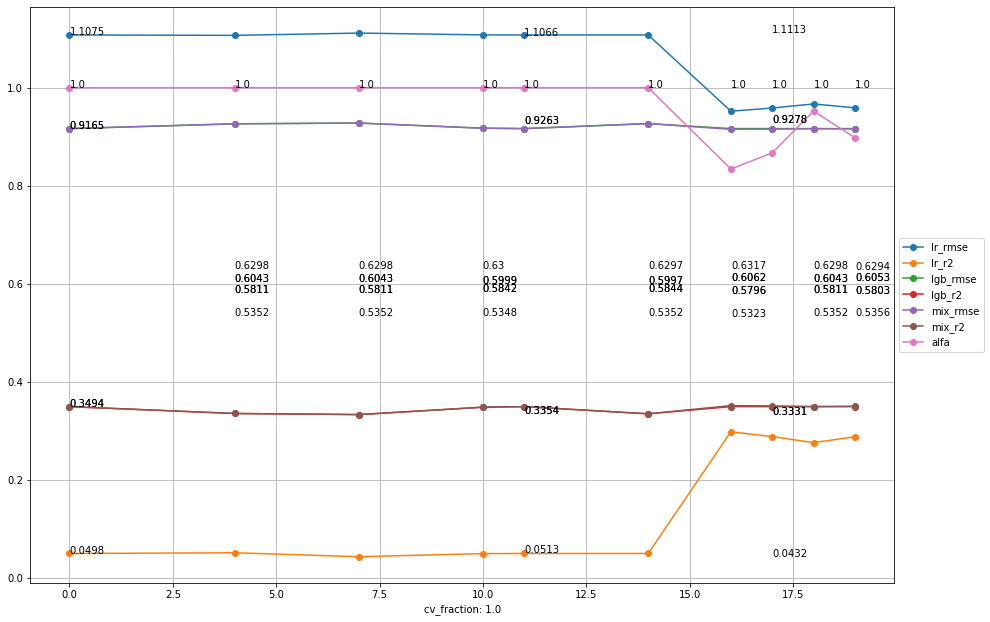

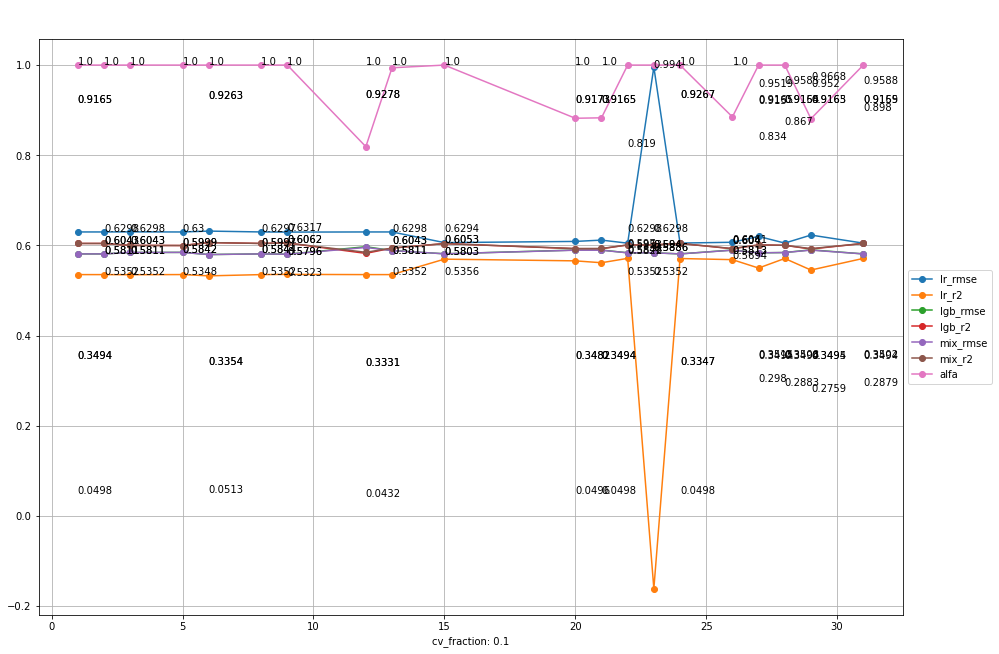

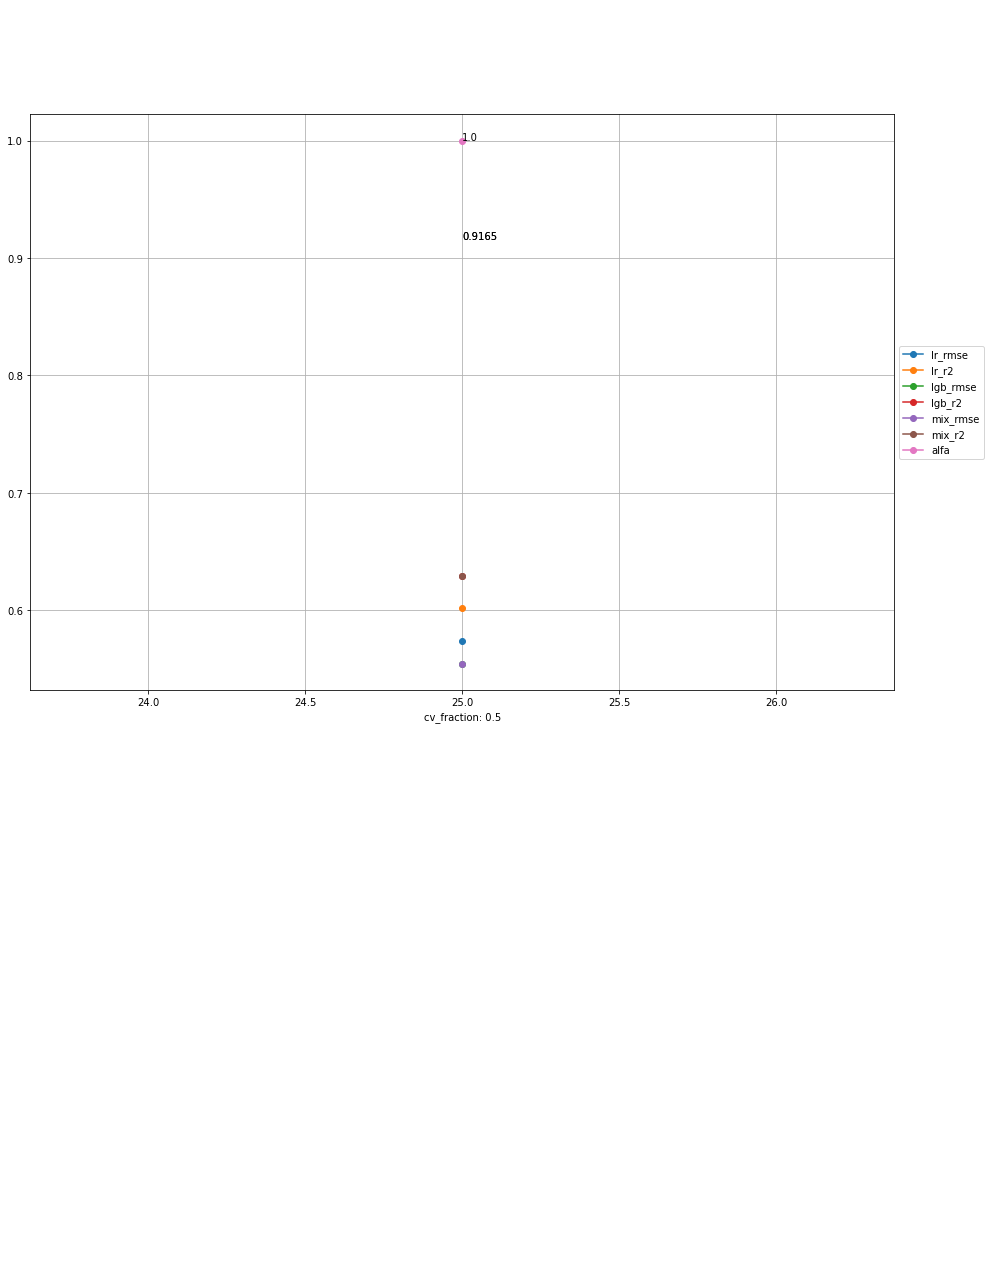

In [19]:

for cv_fraction in metrics['cv_fraction'].unique():
    ax =plt.axes([0, 0, 2, 2])
    for col in columns:
        sub_metrix = metrics[metrics['cv_fraction'] == cv_fraction]
        ax.plot(sub_metrix.index, sub_metrix[col], marker='.', linestyle='-', ms=12, label=col)
        for i,j in zip(sub_metrix.index,metrics[col]):
            ax.annotate(str(round(j,4)),xy=(i,j))
        plt.xlabel(f'cv_fraction: {cv_fraction}')

    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.grid(True)
    plt.show()

In [20]:

# ROUND II
# TRAIN MODELS ON COMPLETE DATA SET AND GETTING PREDICTIONS FOR SUBMITING
X_train_lr, X_test_lr = preprocess_for_linear(X_train, X_test)
# pred_lr = train_and_predict_lr(X_train_lr, Y_train, X_test_lr, 'lr_model_full')
be.fit(X_train_lr, Y_train)
pred_lr = be.predict(X_test_lr)

del X_train_lr, X_test_lr
gc.collect();

pred_tree = train_and_predict_lgbm(X_train, Y_train, X_test, lgb_parameters, 'lgb_model_train')

X_train_level2 = np.c_[pred_tree, pred_lr]

result = get_mix(best_alpha, X_train_level2)

get_result_df(result).to_csv('result_lgb+lr.csv', index=False)
# Your public and private LB scores are: 0.962927 and 0.963253.
get_result_df(pred_tree).to_csv('result_lgb.csv', index=False)
print("DONE!")


training lgb_model_train by parameters
DONE!


In [21]:
round(time.time() - start)/60

21.733333333333334

## Result
you can send result_lgb+lr.csv file for evaluation

In [22]:
get_result_df(pred_lr).to_csv('result_lr.csv', index=False)